<a href="https://colab.research.google.com/github/Nobel712/AutoEncoder/blob/main/Anomaly_detection_LSTMAutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers  import LSTM,Input,Dropout,Dense,RepeatVector,TimeDistributed
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns

In [4]:
datafram=pd.read_csv('/content/GE.csv')
df=datafram[['Date','Close']]
df['Date']=pd.to_datetime(df['Date'])

<ipython-input-4-4511947ccdee>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date']=pd.to_datetime(df['Date'])


<Axes: xlabel='Date', ylabel='Close'>

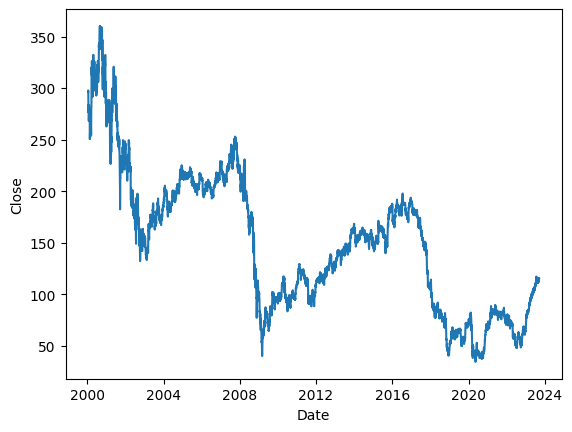

In [5]:
sns.lineplot(x=df.Date,y=df.Close)

In [6]:
df.Date.min()

Timestamp('2000-01-18 00:00:00')

In [7]:
train,test=df.loc[df['Date']<='2014-01-18'],df.loc[df.Date>'2014-01-18']

In [8]:
scaler=StandardScaler()
scaler=scaler.fit(train[['Close']])
train['Close']=scaler.transform(train[['Close']])
test['Close']=scaler.transform(test[['Close']])

<ipython-input-8-3eb17dc372e6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Close']=scaler.transform(train[['Close']])
<ipython-input-8-3eb17dc372e6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Close']=scaler.transform(test[['Close']])


In [13]:
seq_size=30
def to_sequences(x,y, seq_size=1):
  y_values=[]
  x_values=[]
  for i in range(len(x)-seq_size):
    x_values.append(x.iloc[i:(i+seq_size)].values)
    y_values.append(y.iloc[i+seq_size])

  return np.array(x_values),np.array(y_values)
trainx,trainy=to_sequences(train[['Close']], train['Close'], seq_size)
testx,testy=to_sequences(test[['Close']], test['Close'], seq_size)

autoencoder


In [14]:
model=Sequential()
model.add(LSTM(128, input_shape=(trainx.shape[1], trainx.shape[2])))
model.add(Dropout(rate=0.2))
model.add( RepeatVector(trainx.shape[1]))

model.add(LSTM(128,return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(trainx.shape[2])))
model.compile(optimizer='adam',loss='mae')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 repeat_vector (RepeatVecto  (None, 30, 128)           0         
 r)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           131584    
                                                                 
 dropout_1 (Dropout)         (None, 30, 128)           0         
                                                                 
 time_distributed (TimeDist  (None, 30, 1)             129       
 ributed)                                             

In [16]:
history=model.fit(trainx,trainy,epochs=10,batch_size=32,validation_split=0.1,verbose=1)

Epoch 1/10
99/99 [==============================] - 18s 133ms/step - loss: 0.8352 - val_loss: 0.6694
Epoch 2/10
99/99 [==============================] - 12s 121ms/step - loss: 0.8347 - val_loss: 0.6886
Epoch 3/10
99/99 [==============================] - 12s 123ms/step - loss: 0.8326 - val_loss: 0.7361
Epoch 4/10
99/99 [==============================] - 11s 108ms/step - loss: 0.8333 - val_loss: 0.7800
Epoch 5/10
99/99 [==============================] - 11s 111ms/step - loss: 0.8324 - val_loss: 0.7231
Epoch 6/10
99/99 [==============================] - 12s 116ms/step - loss: 0.8324 - val_loss: 0.7185
Epoch 7/10
99/99 [==============================] - 13s 131ms/step - loss: 0.8324 - val_loss: 0.7091
Epoch 8/10
99/99 [==============================] - 10s 102ms/step - loss: 0.8326 - val_loss: 0.7589
Epoch 9/10
99/99 [==============================] - 11s 111ms/step - loss: 0.8321 - val_loss: 0.7650
Epoch 10/10
99/99 [==============================] - 7s 67ms/step - loss: 0.8322 - val_loss

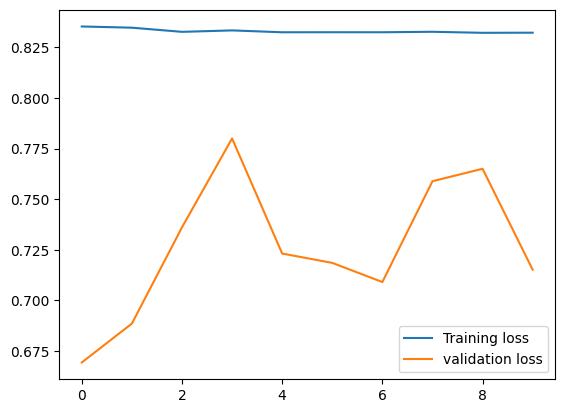

In [19]:
plt.plot(history.history['loss'],label='Training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()

In [20]:
pred=model.predict(trainx)

110/110 [==============================] - 3s 26ms/step


(array([376., 465., 387., 252., 170., 298., 120., 156., 210., 155., 210.,
        284.,  53., 109.,  88.,  74.,  28.,  14.,  16.,  28.]),
 array([0.05503805, 0.17520699, 0.29537593, 0.41554486, 0.5357138 ,
        0.65588274, 0.77605167, 0.89622061, 1.01638955, 1.13655849,
        1.25672742, 1.37689636, 1.4970653 , 1.61723423, 1.73740317,
        1.85757211, 1.97774105, 2.09790998, 2.21807892, 2.33824786,
        2.45841679]),
 <BarContainer object of 20 artists>)

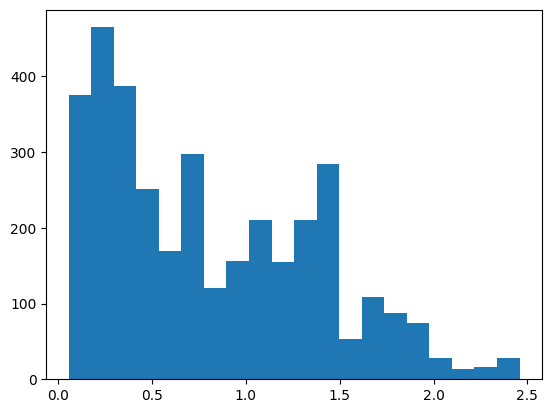

In [22]:
trainMAE=np.mean(np.abs(pred-trainx),axis=1)
plt.hist(trainMAE,bins=20)

76/76 [==============================] - 3s 35ms/step


(array([230., 144.,  53., 149., 257.,  88.,   9.,   7.,   7.,   7.,  77.,
         51.,  36.,  95., 290., 228., 189., 223.,  92., 169.]),
 array([0.01759155, 0.12876725, 0.23994295, 0.35111864, 0.46229434,
        0.57347003, 0.68464573, 0.79582143, 0.90699712, 1.01817282,
        1.12934852, 1.24052421, 1.35169991, 1.4628756 , 1.5740513 ,
        1.685227  , 1.79640269, 1.90757839, 2.01875409, 2.12992978,
        2.24110548]),
 <BarContainer object of 20 artists>)

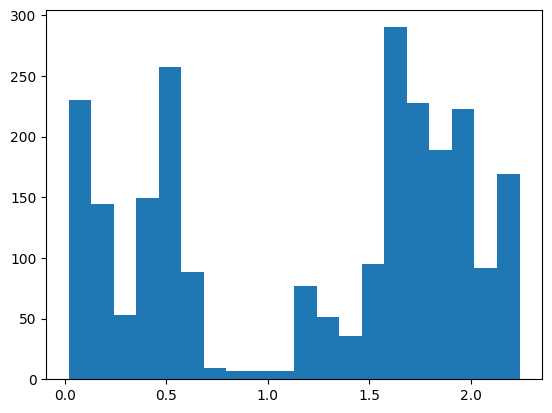

In [23]:
max_trainMAE=0.3
testpred=model.predict(testx)
testmae=np.mean(np.abs(testpred-testx),axis=1)
plt.hist(testmae, bins=20)

In [24]:
anomaly_df=pd.DataFrame(test[seq_size:])
anomaly_df['testmae']=testmae
anomaly_df['max_trainMAE']=max_trainMAE
anomaly_df['anomaly']=anomaly_df['testmae']>anomaly_df['max_trainMAE']
anomaly_df['Close']=test[seq_size:]['Close']

<Axes: xlabel='Date', ylabel='testmae'>

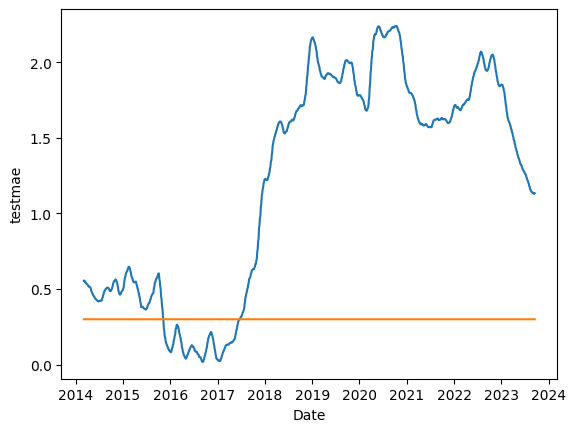

In [25]:
sns.lineplot(x=anomaly_df.Date, y=anomaly_df.testmae)
sns.lineplot(x=anomaly_df.Date,y=anomaly_df.max_trainMAE)

In [27]:
anomalies=anomaly_df.loc[anomaly_df.anomaly==True]
anomalies

,Date,Close,testmae,max_trainMAE,anomaly
3553,2014-03-05,-0.336112,0.554263,0.3,True
3554,2014-03-06,-0.309267,0.555948,0.3,True
3555,2014-03-07,-0.317598,0.555861,0.3,True
3556,2014-03-10,-0.325930,0.555071,0.3,True
3557,2014-03-11,-0.338889,0.551667,0.3,True
...,...,...,...,...,...
5949,2023-09-11,-0.975053,1.135138,0.3,True
5950,2023-09-12,-0.963645,1.135690,0.3,True
5951,2023-09-13,-0.985227,1.135683,0.3,True
5952,2023-09-14,-0.953625,1.135362,0.3,True


In [32]:
sns.lineplot(x=anomaly_df.Date, y=scaler.inverse_transform(anomaly_df.Close))
sns.scatterplot(x=anomalies.Date,y=scaler.inverse_transform(anomalies.Close),color='r')

ValueError: ignored